In [70]:
%%capture
import os, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, plot_precision_recall_curve, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
sess = tf.Session()

## Data Preparation

In [75]:
# read in data 
data = pd.read_csv("../data/DataMatched.txt", delimiter="\t")
data.rename(columns={"Unnamed: 0":"features"}, inplace=True)
#data.set_index('features')
# drop last row.  since it has NaN values
data.drop(data.tail(1).index,inplace=True)

In [76]:
# read in target info
target = pd.read_csv("../data/TargetMutations.txt", delimiter="\t")
target.rename(columns={"Unnamed: 0":"features"}, inplace=True)
#target.set_index('features')

In [77]:
# read in info
info = pd.read_csv("../data/infoMatched.txt", delimiter="\t")
info.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

In [78]:
# save/load tp53 target
targetpath = "../data/tp53.npy"
if not os.path.exists(targetpath):
    y = target.loc[target["features"] == "TP53"].values
    y = np.asarray(y.tolist()[0][1:])
    np.save(targetpath, y)
else: 
    y = np.load(targetpath, allow_pickle=True)

In [79]:
# setup data frame for merge
data.set_index(keys="features", inplace=True)
trans_data = data.T
trans_data.reset_index(inplace=True)
trans_data.rename(columns={"index":"SAMPLE_BARCODE"}, inplace=True)
trans_data.set_index("SAMPLE_BARCODE", inplace=True)

In [80]:
# setup info frame for merge
info.set_index("SAMPLE_BARCODE", inplace=True)
info.drop(columns=["PATIENT_BARCODE", "SUBTYPE"], axis=1, inplace=True)

# change DISEASE to DISEASE_ID  

## create disease dictionary
diseases = info.DISEASE.unique()
disease_dict = dict(zip(diseases, range(len(diseases))))
invdisease_dict = {v: k for k, v in disease_dict.items()} # needed for visualization

## DISEASE -> DISEASE_ID
info["DISEASE_ID"] = info["DISEASE"].map(disease_dict)
info.drop(columns=["DISEASE"], axis=1, inplace=True)
print("Disease Dictionary")
print(disease_dict)
print()
print("Inverse Disease Dictionary")
print(invdisease_dict)

Disease Dictionary
{'KICH': 28, 'UCEC': 5, 'ESCA': 8, 'BRCA': 14, 'TGCT': 7, 'STAD': 18, 'DLBC': 27, 'HNSC': 23, 'LUSC': 3, 'SKCM': 19, 'UCS': 29, 'OV': 1, 'BLCA': 6, 'SARC': 13, 'LUAD': 2, 'MESO': 16, 'UVM': 32, 'LIHC': 11, 'CESC': 12, 'PAAD': 9, 'ACC': 30, 'KIRP': 10, 'LAML': 24, 'PRAD': 4, 'CHOL': 20, 'READ': 25, 'PCPG': 31, 'GBM': 0, 'COAD': 17, 'LGG': 26, 'THYM': 15, 'THCA': 22, 'KIRC': 21}

Inverse Disease Dictionary
{0: 'GBM', 1: 'OV', 2: 'LUAD', 3: 'LUSC', 4: 'PRAD', 5: 'UCEC', 6: 'BLCA', 7: 'TGCT', 8: 'ESCA', 9: 'PAAD', 10: 'KIRP', 11: 'LIHC', 12: 'CESC', 13: 'SARC', 14: 'BRCA', 15: 'THYM', 16: 'MESO', 17: 'COAD', 18: 'STAD', 19: 'SKCM', 20: 'CHOL', 21: 'KIRC', 22: 'THCA', 23: 'HNSC', 24: 'LAML', 25: 'READ', 26: 'LGG', 27: 'DLBC', 28: 'KICH', 29: 'UCS', 30: 'ACC', 31: 'PCPG', 32: 'UVM'}


In [81]:
# merge features w/ disease_id
frame = trans_data.merge(info, on="SAMPLE_BARCODE")
frame.reset_index(inplace=True)
frame.drop("SAMPLE_BARCODE", axis=1, inplace=True)

# add target to dataframe
frame["target"] = y
frame.head(1)

,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,SLC22A15,SLC22A1,SLC22A16,SLC22A17,SLC22A18,SLC22A18AS,SLC22A20,SLC22A23,DISEASE_ID,target
0,6.445364,0.061528,7.602398,5.106361,15.38323,4.665664,4.43449,0.866948,0.866948,8.743729,...,5.720371,0.482858,1.149002,12.084891,5.205603,0.482858,0.061528,10.121061,0,0


## Train/Validate/Visualize

In [83]:
# check for NaNs
assert(frame.shape == frame.dropna(how="all").shape)  
assert(frame.dropna(how="all").shape == frame.dropna(how="any").shape)

# remove UVM disease fold
frame = frame.loc[frame["DISEASE_ID"] != "UVM"] # UVM fold is resulting in a NaN mean so remove for now 

/usr/local/lib/python3.5/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [82]:
# # test code on shrunken dataframe
# frame = frame.drop_duplicates(subset=["DISEASE_ID"], keep="first")
# frame = pd.concat((frame, frame, frame))
# frame.shape

['TP53', 'PIK3CA', 'KRAS', 'PTEN', 'ARID1A', 'RB1', 'FBXW7', 'NRAS', 'CDKN2A', 'CTNNB1']


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

defaultdict(<class 'float'>, {'TP53': 0.8431678601272479})


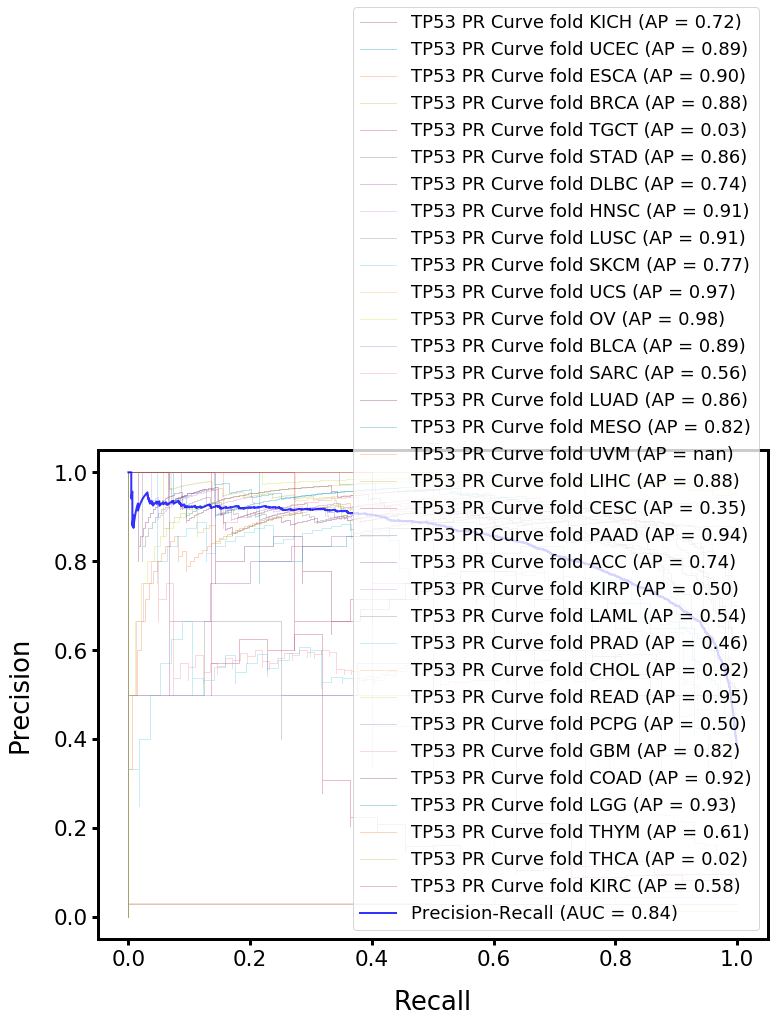

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local

defaultdict(<class 'float'>, {'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117})


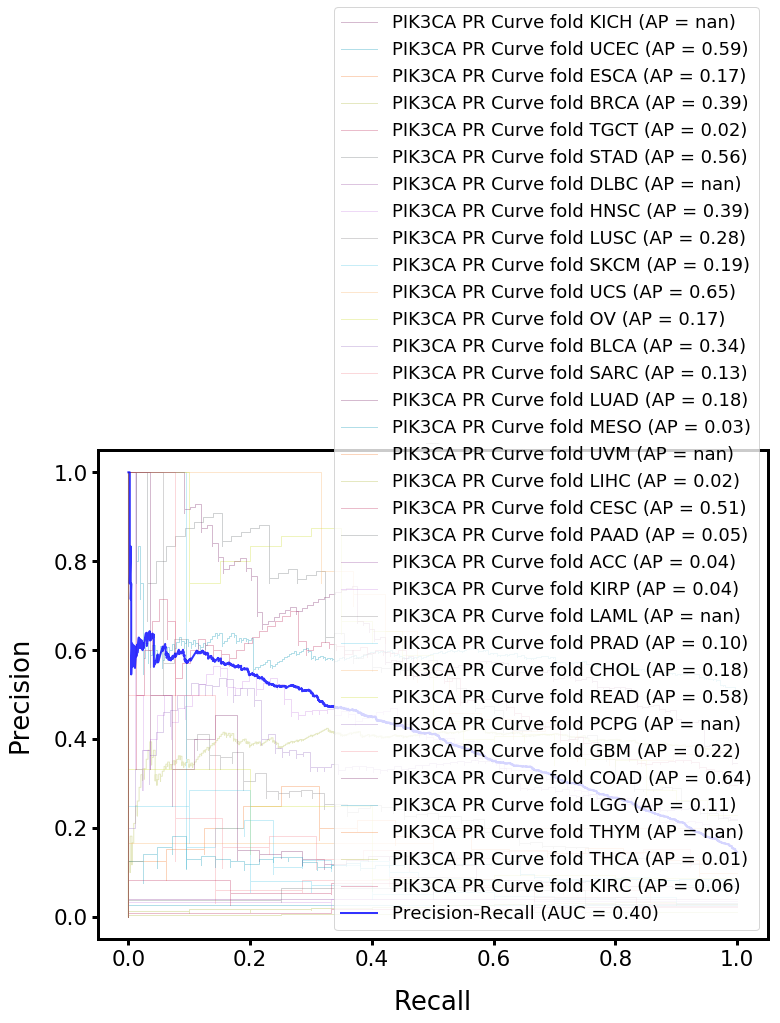

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local

defaultdict(<class 'float'>, {'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117, 'KRAS': 0.4873382124725437})


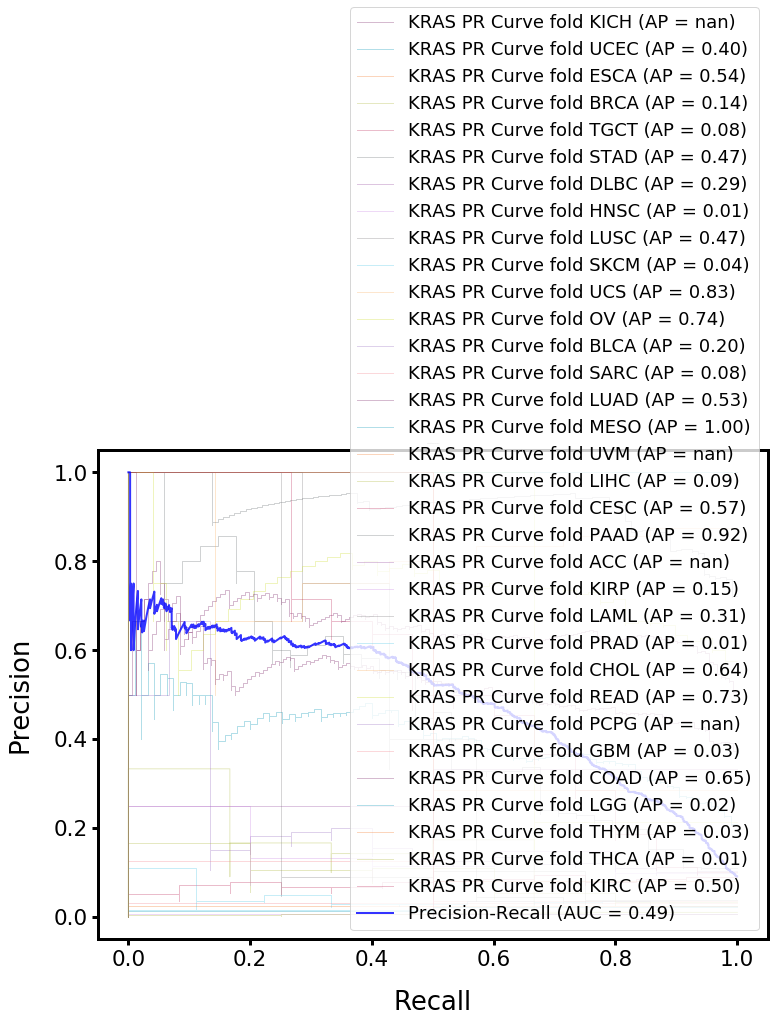

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

defaultdict(<class 'float'>, {'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437})


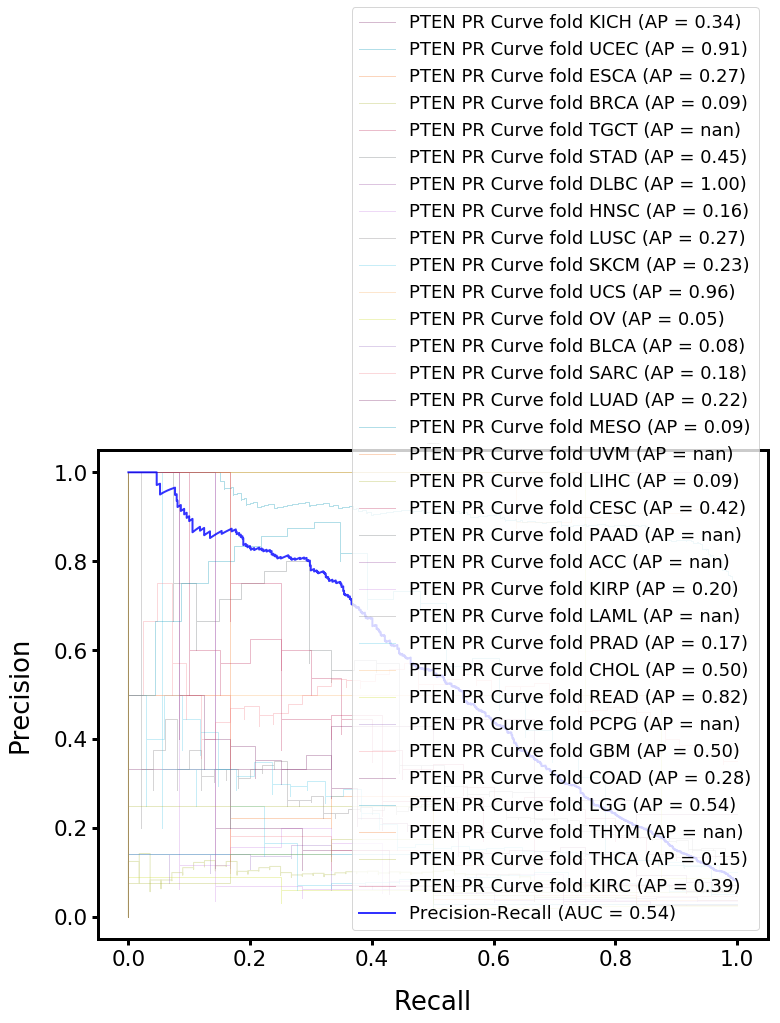

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local

defaultdict(<class 'float'>, {'ARID1A': 0.5409627819349359, 'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437})


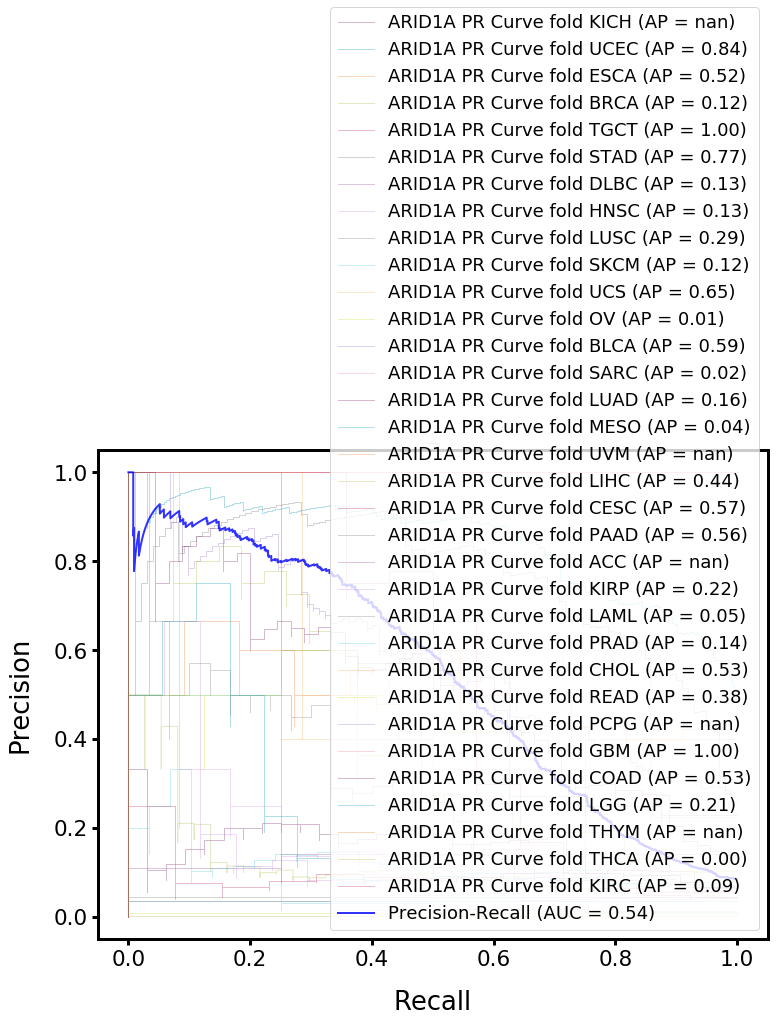

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

defaultdict(<class 'float'>, {'RB1': 0.2080021331735764, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437, 'ARID1A': 0.5409627819349359, 'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117})


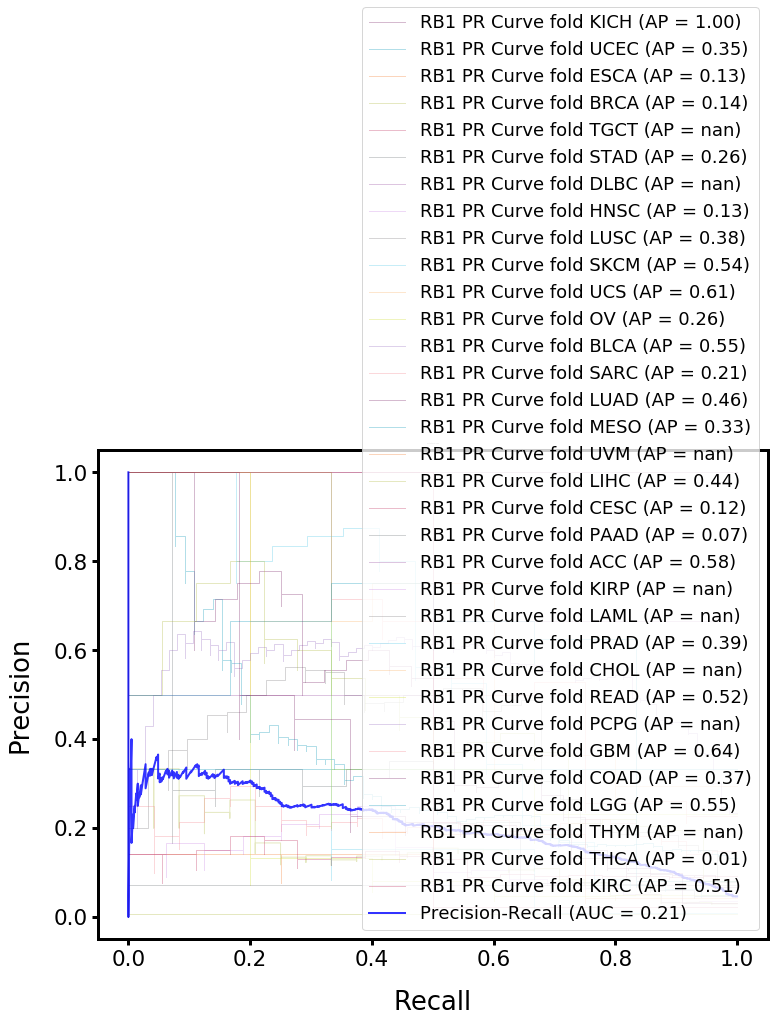

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local

defaultdict(<class 'float'>, {'RB1': 0.2080021331735764, 'FBXW7': 0.4591044030242563, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437, 'ARID1A': 0.5409627819349359, 'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117})


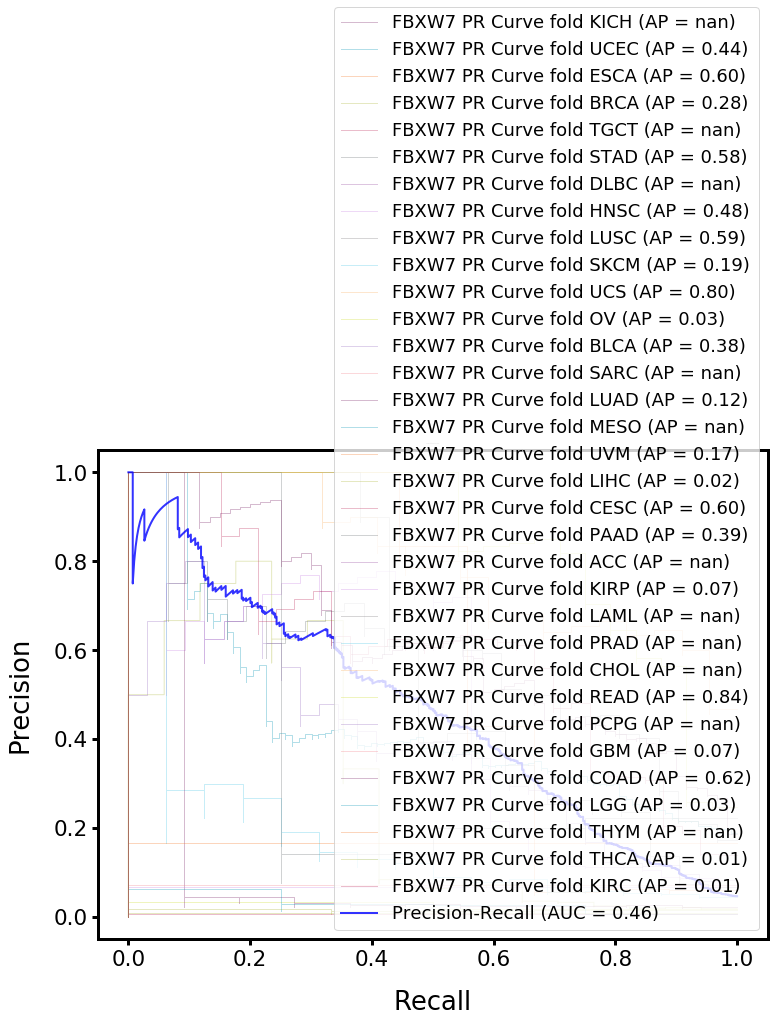

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

defaultdict(<class 'float'>, {'RB1': 0.2080021331735764, 'FBXW7': 0.4591044030242563, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437, 'ARID1A': 0.5409627819349359, 'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117, 'NRAS': 0.05166164794521935})


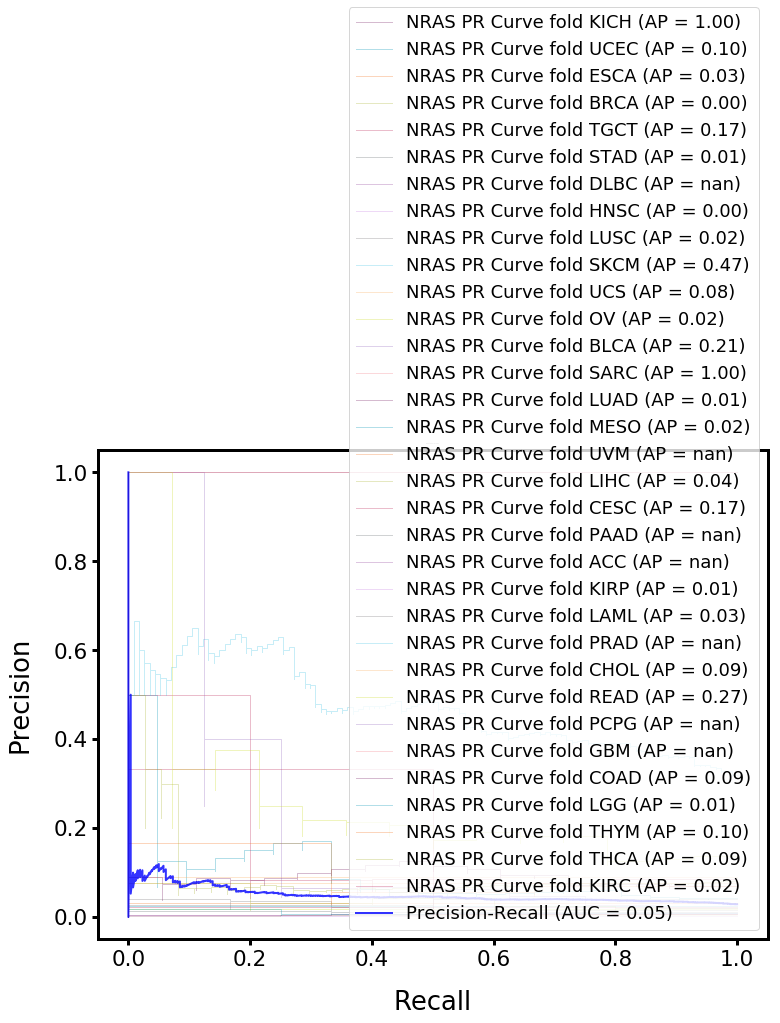

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local

defaultdict(<class 'float'>, {'RB1': 0.2080021331735764, 'FBXW7': 0.4591044030242563, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437, 'ARID1A': 0.5409627819349359, 'CDKN2A': 0.15154645961780927, 'TP53': 0.8431678601272479, 'PIK3CA': 0.4047533592626117, 'NRAS': 0.05166164794521935})


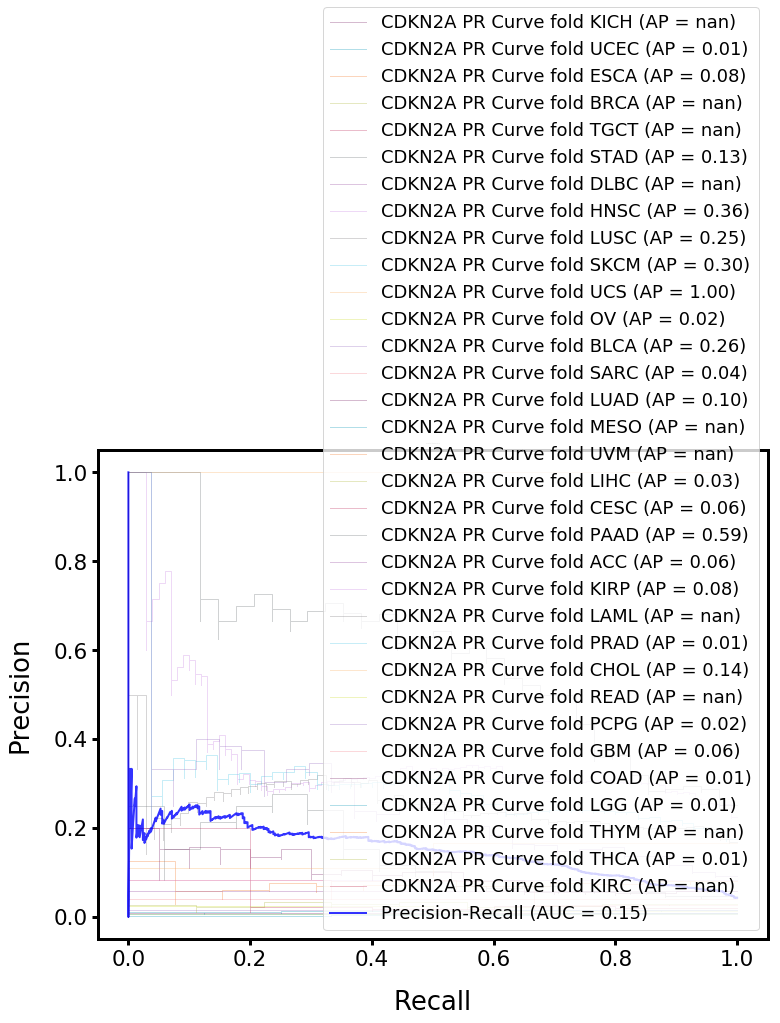

<Figure size 792x792 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

defaultdict(<class 'float'>, {'RB1': 0.2080021331735764, 'FBXW7': 0.4591044030242563, 'PTEN': 0.5439590872742054, 'KRAS': 0.4873382124725437, 'ARID1A': 0.5409627819349359, 'CDKN2A': 0.15154645961780927, 'TP53': 0.8431678601272479, 'CTNNB1': 0.3598771440099032, 'PIK3CA': 0.4047533592626117, 'NRAS': 0.05166164794521935})


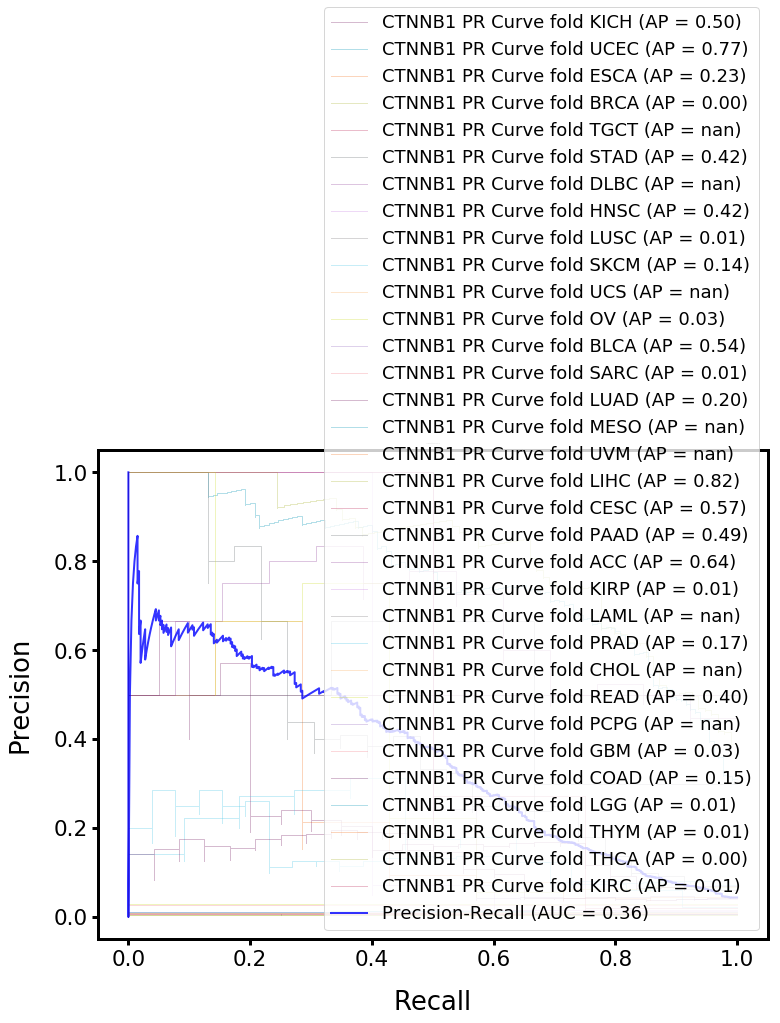

<Figure size 792x792 with 0 Axes>

In [84]:
## save additional proteins to be used as Y targets 
more_proteins = "TP53,PIK3CA,KRAS,PTEN,ARID1A,RB1,FBXW7,NRAS,CDKN2A,CTNNB1"
more_proteins=more_proteins.split(",")
print(more_proteins)

# store mean_auc + mean_aupr for each Y value in more_proteins
y_mean_aucs = defaultdict(float)
y_mean_auprs = defaultdict(float)

for prot in more_proteins: 
    # store target for training
    y = target.loc[target["features"] == prot].values
    y = np.asarray(y.tolist()[0][1:])
    # y = y[:99]
    frame["target"] = y 
    y_prot_name = prot
    
    random_state=777
    # define elasticnet classifier
    classifier = LogisticRegression(penalty="elasticnet", random_state=random_state, solver="saga", l1_ratio=.5, n_jobs=-1)

    # store parameters for ROC + AUPR Visualization/Analysis
    
    ## AUPR Variables
    y_real = []
    y_proba = []

    # train/predict
    fig, ax = plt.subplots()
    for disease_index in list(disease_dict.values()): 
        # split data based on disease class
        train = frame.loc[frame["DISEASE_ID"] != disease_index]
        test = frame.loc[frame["DISEASE_ID"] == disease_index]
    
        # drop disese id (frame -> X|y)
        train.drop(columns=["DISEASE_ID"], axis=1)
        test.drop(columns=["DISEASE_ID"], axis=1)
    
        # save y_train, y_test
        y_train, y_test = train["target"], test["target"]
    
        # drop target (X|y -> X)
        X_train, X_test = train.drop(columns=["target"], axis=1), test.drop(columns=["target"], axis=1)
    
        # fit model + save probabilities for aupr 
        probas_ = classifier.fit(X_train, y_train).predict_proba(X_test) 
        
        # save predictions for future analysis
        preds = classifier.fit(X_train, y_train).predict(X_test) 
        predpath = "../data/" + y_prot_name + "_" + invdisease_dict[disease_index] + "_STRATPREDS.npy"
        np.save(predpath, preds)
        
        viz = plot_precision_recall_curve(classifier, X_test, y_test,
                             name=y_prot_name + ' PR Curve fold {}'.format(invdisease_dict[disease_index]),
                             alpha=0.3, lw=1, ax=ax)
        y_real.append(y_test)
        y_proba.append(probas_[:, 1])
    
    # visualize 
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    
    # update + save y_mean_auprs for plotting against unstratified y_mean_auprs
    y_mean_auprs[y_prot_name] = average_precision_score(y_real, y_proba)
    print(y_mean_auprs)
    y_mean_auprs_path =  "../data/strat_mean_auprs.pkl"
    pickle.dump(y_mean_auprs, open(y_mean_auprs_path, "wb" ))
    
    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Precision-Recall curve")
    ax.set_title(y_prot_name + "Stratified PR Curve")
    ax.legend(loc="lower right")
    plt.figure(figsize=(11,11))
    plt.show()

## Stratified Aggregate Plots 

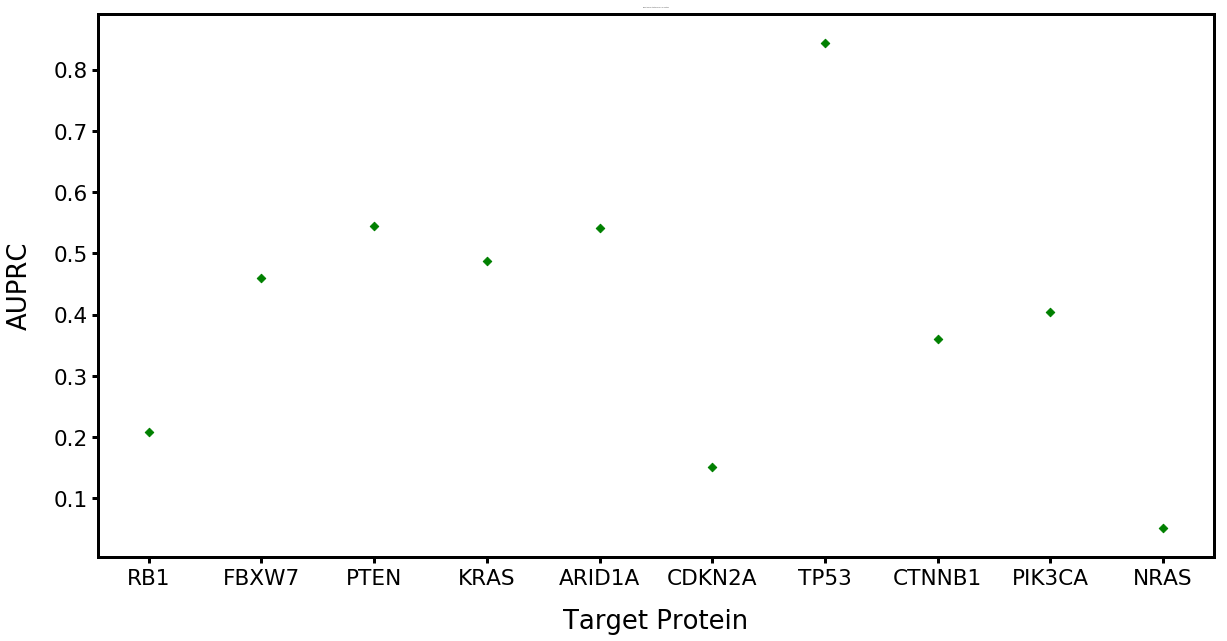

In [86]:
# plot mean AUPR for sratified kFold Cross Validation
xx = y_mean_auprs.keys()
yy = y_mean_auprs.values()
plt.figure(figsize=(20,10))
plt.xlabel("Target Protein")
plt.ylabel("AUPRC")
plt.scatter(xx,yy, color="green", marker="D")
plt.title("Mean AUPRC for Stratified 5-Fold Cross Validation")
plt.show()